In [1]:
# pip install ipywidgets

# 3 | _Prophet_ Modeling: Ridership, All Ridership
---
* [01 API Data Requests](01_API_pulls.ipynb)
* [01.1 Additional BART Data](01_v2_bart.ipynb.ipynb)
* [02 Initial EDA](02_EDA.ipynb)
* _[03 First Model: Prophet](03_prophet.ipynb)_
---

This notebook documents `1` model: using Facebook's `Prophet` to forecast ridership. 

* `Jan 2000` - `Apr 2022` monthly data is used. 

The model does NOT perform well. Data from ridership decline toward end of `2018` and abrupt change in `March 2022` due to COVID provide a negative trend, so the forecasts are VERY BAD. 
    * Prophet is designed to _detect_ changes, but only does so on the very first `80%` of the data, which does not include the years of interest. Manual changepoints can be visualized and implemented. 

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import plotly.io as pio

In [5]:
# CUSTOMS 
plt.style.use('gstyle.mplstyle')
pio.templates.default = "plotly_dark"

import warnings
warnings.filterwarnings('ignore')

#### Function below: ensures appropriate date time `type` AND `index`, and `ds` for `Prophet` to use.

In [9]:
def date_index(df): 
    df['date'] = pd.to_datetime(df['ds'])
    df = df.set_index('date')
    df.rename(columns = {'ridership' : 'y'}, inplace = True)

    return(df)

## Ridership with Prophet

In [10]:
# importing bart data
filename = 'bart_daily.csv'
file = '../data/processed/' + filename
bart_df = pd.read_csv(file)

bart_df.head()

bart_df = date_index(bart_df)

bart_df.head()

,y,ds
date,,
2011-01-01,124162.0,2011-01-01
2011-01-02,93666.0,2011-01-02
2011-01-03,285891.0,2011-01-03
2011-01-04,322306.0,2011-01-04
2011-01-05,327006.0,2011-01-05


In [15]:
# # importing fuel data
# file = '../data/processed/fuel_m.csv'
# fuel_df = pd.read_csv(file)
# fuel_df = date_index(fuel_df)

In [7]:
# # merging data 
# merged = bart_df.merge(fuel_df['fuel_m'], right_on = 'date', left_on = 'date')
# # merged['ds'] = pd.to_datetime(merged['ds'])
# merged.rename(columns = { 'ridership' : 'y'}, inplace = True)
# merged = merged['2010-01-01':'2020-01-01']

# train_df = merged[: '2019-12-01']
# test_df = merged['2020-01-01':]
# train_df.head()

In [15]:
start_date = '2018-01-01'
end_date = '2020-01-01'
train_start = '2020-01-01'
train_end = '2021-01-03'

train_df = bart_df[start_date : end_date]
test_df = bart_df[end_date: train_end]
# test_df = merged['2020-01-01':]
train_df.head()

,y,ds
date,,
2018-01-01,109240.0,2018-01-01
2018-01-01,24121.0,2018-01-01
2018-01-02,330888.0,2018-01-02
2018-01-03,360173.0,2018-01-03
2018-01-04,368281.0,2018-01-04


In [16]:
m = Prophet()       # instantiate Prophet model

# # with additional regressor:
# pro_regressor.add_regressor('fuel_m')

# fit data 
m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -102.227


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       1335.29   0.000453864       101.401   4.328e-06       0.001      149  LS failed, Hessian reset 
      99       1335.31   3.14888e-05       82.6067      0.5216      0.5216      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       1335.32   3.54611e-06       96.5854   3.799e-08       0.001      252  LS failed, Hessian reset 
     163       1335.32   4.96685e-08       88.0664      0.1861           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [17]:
# make future df 
future_data = m.make_future_dataframe( periods = 365) 

# forecast on test data
forecast = m.predict(test_df)
# forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
360,2020-12-30,311401.813519,217995.505381,344975.257461,311401.607131,311402.027317,-32656.799047,-32656.799047,-32656.799047,86457.631768,86457.631768,86457.631768,-119114.430815,-119114.430815,-119114.430815,0.0,0.0,0.0,278745.014472
361,2020-12-31,311383.437927,217927.956562,339224.219761,311383.230148,311383.652537,-32492.110256,-32492.110256,-32492.110256,86879.585495,86879.585495,86879.585495,-119371.695751,-119371.695751,-119371.695751,0.0,0.0,0.0,278891.327671
362,2021-01-01,311365.062334,188297.797254,308264.460159,311364.853342,311365.277750,-61345.749663,-61345.749663,-61345.749663,56936.731555,56936.731555,56936.731555,-118282.481218,-118282.481218,-118282.481218,0.0,0.0,0.0,250019.312672
363,2021-01-02,311346.686742,-28597.435863,96176.664765,311346.476882,311346.902963,-275164.052353,-275164.052353,-275164.052353,-159293.767202,-159293.767202,-159293.767202,-115870.285150,-115870.285150,-115870.285150,0.0,0.0,0.0,36182.634389
364,2021-01-03,311328.311150,-70402.123624,51802.585372,311328.100550,311328.528311,-318646.950760,-318646.950760,-318646.950760,-206461.218110,-206461.218110,-206461.218110,-112185.732649,-112185.732649,-112185.732649,0.0,0.0,0.0,-7318.639610


In [ ]:
# fore2 = forecast
# fore2['y'] = test_df['y']

: 

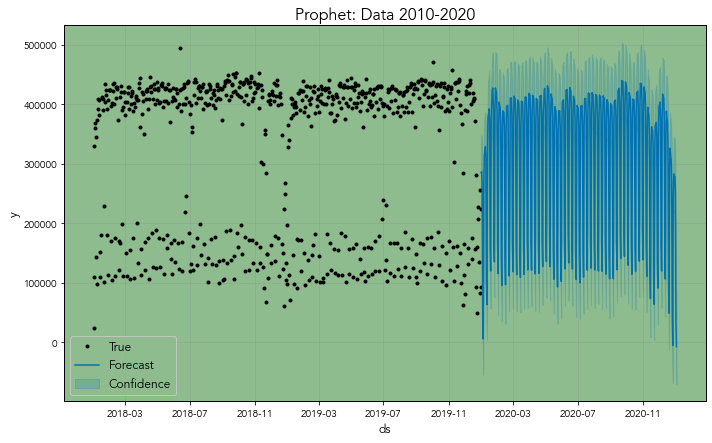

In [18]:
m.plot(forecast);
plt.title(label = 'Prophet: Data 2010-2020', fontsize=16)
plt.legend(['True', 'Forecast', 'Confidence']); 

In [19]:
# make future df 
future_data = m.make_future_dataframe( periods = 365) 

# forecast on test data
forecast = m.predict(test_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
360,2020-12-30,278745.014472,211783.183144,337288.527802
361,2020-12-31,278891.327671,216699.937287,339539.934002
362,2021-01-01,250019.312672,188877.388568,309947.020337
363,2021-01-02,36182.634389,-25127.701354,99125.312719
364,2021-01-03,-7318.639610,-71405.554577,56038.375699


> #### Visualizing changepoints to implement: 

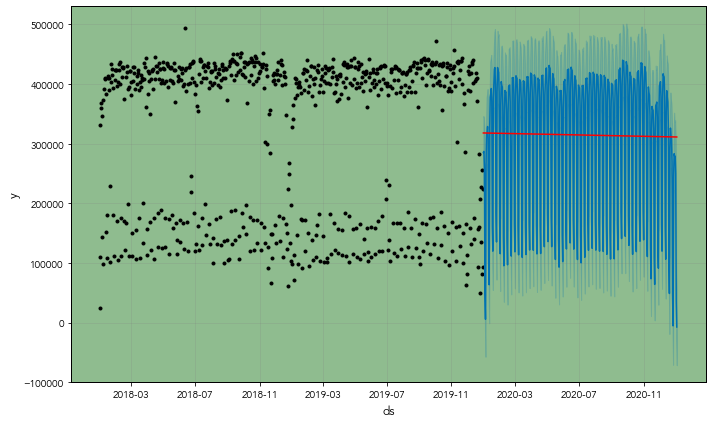

In [20]:
# Python
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


In [21]:
preds = forecast.yhat
trues = test_df.y
preds.index = trues.index
preds.shape, trues.shape

((365,), (365,))

> #### Errors on first fit: 

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math

mae = mean_absolute_error(trues, preds)
mse = mean_squared_error(trues, preds)
rmse = math.sqrt(mse)
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

MAE: 233665.194746
MSE: 73782285017.475250
RMSE: 271628.947311


ID      | MODEL   | DATA      | RMSE        | MSE       | MAE       | CV        | MAPE      | MASE      | AIC 
---     | ---     | ---        | ---       | ---       | ---       | ---       | ---       | ---       | ---  
A       | PROPHET | < 2019   | 446 152   | 199 052 198 567| 375 686   |          
B       | PROPHET | All BART   | 1 243 269   | 5 457 200 928 927| 1 181 450   |          

> ## Cross Validation over subsets of series: 
> * train on `5` years 
> * spit every window for `2` years
> * forecast for `1` year

In [27]:
# Python
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model = m, 
    initial ='365 days',   # pd.to_timedelta(30*12,unit="D") 
    period ='365 days',     # pd.to_timedelta(30*12,unit="D")
    horizon = '365 days')

### Can also use manual cut-offs 
# cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
# df_cv2 = cross_validation(pro_regressor, cutoffs=cutoffs, horizon='365 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2019-01-01 00:00:00 and 2019-01-01 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -51.7188
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       677.965   0.000144217        88.326      0.6344      0.6344      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       678.495   7.39341e-05       100.695   7.304e-07       0.001      214  LS failed, Hessian reset 
     186         678.5   1.21639e-08       98.6149      0.3895           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [28]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-02,251383.898977,191015.045954,311509.146821,328218.0,2019-01-01
1,2019-01-03,254082.821962,194852.093190,316891.465549,364931.0,2019-01-01
2,2019-01-04,226615.331251,164711.468411,288215.033928,340950.0,2019-01-01
3,2019-01-05,15959.304301,-45939.667237,72657.069300,112630.0,2019-01-01
4,2019-01-06,-26447.011110,-85012.165800,33858.256139,71724.0,2019-01-01


In [29]:
forecast = m.predict(test_df)

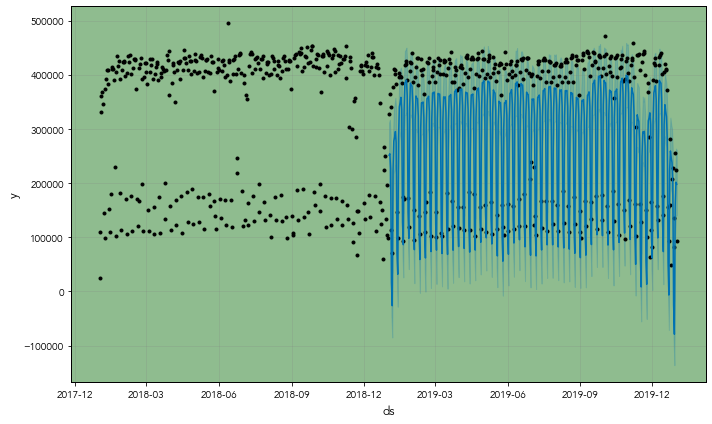

In [30]:
m.plot(df_cv);

In [31]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,6.271815e+09,79194.794567,68551.068401,0.279114,0.176143,0.341862,0.500000
1,37 days,6.263659e+09,79143.284527,68497.316123,0.277442,0.173166,0.339788,0.500000
2,38 days,6.012629e+09,77541.141644,67001.827816,0.273164,0.168922,0.334335,0.527778
3,39 days,5.675838e+09,75338.158212,64681.111922,0.270031,0.168922,0.330100,0.555556
4,40 days,5.477217e+09,74008.221625,63297.185085,0.258506,0.168922,0.304160,0.583333


In [32]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
325,361 days,8.444888e+09,91896.071459,76201.911385,0.528032,0.202363,0.462884,0.500000
326,362 days,8.918326e+09,94436.890003,78052.679122,0.565140,0.202363,0.493089,0.500000
327,363 days,8.970107e+09,94710.649564,78333.892343,0.551544,0.202363,0.463404,0.500000
328,364 days,8.560275e+09,92521.752684,75517.358096,0.545381,0.193741,0.455683,0.527778
329,365 days,8.788645e+09,93747.771253,76969.220462,0.572737,0.202363,0.471438,0.500000


ID      | MODEL   | DATA      | RMSE        | MSE       | MAE       | MAPE      | MASE      | AIC |
---     | ---     | ---        | ---       | ---       | ---       | ---       | ---       | ---       
A       | PROPHET | < 2019   | 446 152   | 199 052 198 567| 375 686   |      
B       | PROPHET | All BART, CV   |167 050   | 2 790 595 000| 1 181 450   | 0.102         

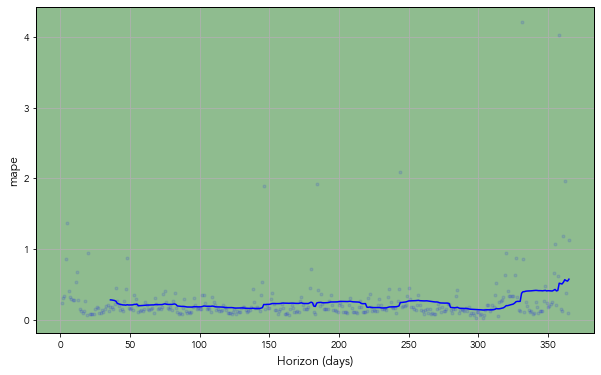

In [33]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

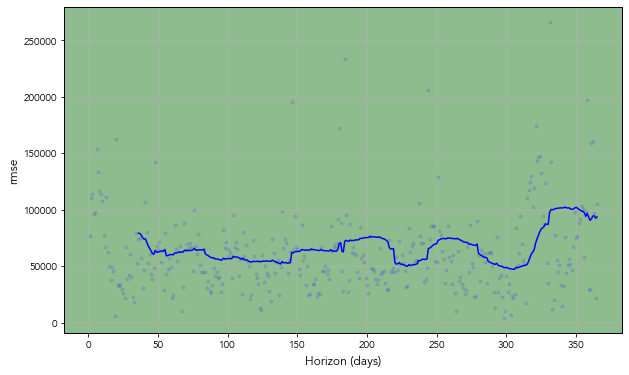

In [34]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
# df = bart

# fig = px.histogram(df, 
#         x = 'day', 
#         y = 'y', 
#         color = 'covid',
#         # marginal='rug', # or violin, rug, box
#         histfunc = 'avg',
#         hover_data = df.columns, 
#         labels = {
#                 'y' : 'Number of Daily Exits', 
#                 'day': 'Day of Week' })
# fig.update_layout(
#         title={
#                 'text': 'BART Daily Ridership by Day of Week, Pre-COVID and After',
#                 'y': 0.9,
#                 'x': 0.5,
#                 'xanchor': 'center',
#                 'yanchor': 'top'}, 
#         legend = dict(
#                 orientation = 'h', 
#                 title = None, 
#                 y = 1.),        # location of legend above chart or within
#         barmode = 'overlay', 
#         ) 
# fig.update_traces(opacity=0.80)
# fig.update_xaxes(categoryorder = 'total ascending')
# fig.show()

# fig.layout.images = [dict(
#         source='https://blog.giovannaguevara.net/wp-content/uploads/2020/02/siteLogo.png',
#         xref="paper", yref="paper",
#         x=0.1, y=1.05,
#         sizex=0.4, sizey=0.4,
#         xanchor="center", yanchor="bottom"
#       )]

# # output HTML for embed
# fname = 'avg_rid.txt'
# plot_out(fname, fig)

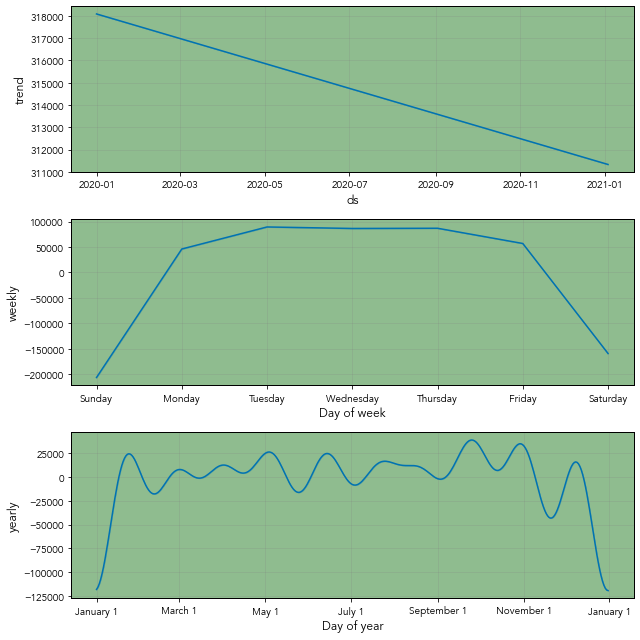

In [35]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

plot_components_plotly(m, forecast)

fig2 = m.plot_components(forecast)